In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(7395, 23)
(7395, 1)


In [6]:
X_motion_CoM_acceleration[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, -0.0007237745555853984,
       0.01639134045253973, -0.004252538996206474, 0.2526783703469499,
       0.13427893772863944, -0.2778846068029694, 0.24869912614405365,
       -0.12366310216804982, -0.3133057085330896, -0.2690074673240338,
       0.1271401124419832, -0.3136605626775182, -0.26988041665563206,
       -0.1350023534415291, -0.2815400304417422, False, True],
      dtype=object)

In [7]:
Y_motion_CoM_acceleration[0:100]

array([[0.08211927296688538],
       [0.08361987936659881],
       [0.0840524986855017],
       [0.09068286841549027],
       [0.08368886175176886],
       [0.0851487670926432],
       [0.09408553030734845],
       [0.08761461494143893],
       [0.08443653754033921],
       [0.08547052154031502],
       [0.09750496859384983],
       [0.08746398362002915],
       [0.08483984076109798],
       [0.08406817674193091],
       [0.0909629086052962],
       [0.08828329909661936],
       [0.08397524013854994],
       [0.0910150876843348],
       [0.0859972387102968],
       [0.09515508767118926],
       [0.09379204922832655],
       [0.08569413357986629],
       [0.08884604529330556],
       [0.08523014267669661],
       [0.09123679151691595],
       [0.08788922956728257],
       [0.08259361817356578],
       [0.0844791133011046],
       [0.08809741356402434],
       [0.09042428311908156],
       [0.08867390786715472],
       [0.08452057017266047],
       [0.08497831554600126],
       [0.091068

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(3697, 23)
(3697, 1)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, -0.0007237745555853984,
       0.01639134045253973, -0.004252538996206474, 0.2526783703469499,
       0.13427893772863944, -0.2778846068029694, 0.24869912614405365,
       -0.12366310216804982, -0.3133057085330896, -0.2690074673240338,
       0.1271401124419832, -0.3136605626775182, -0.26988041665563206,
       -0.1350023534415291, -0.2815400304417422, False, True],
      dtype=object)

In [11]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.08211927296688538], dtype=object)

### Linear Regression

In [12]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [13]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 9:11], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 12:14], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 15:17], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 18:20])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9975545247455827
RMSE:  0.01510205572595716
The lowest error is:  1.0366915533244203e-05
The highest error is:  0.04631931286285196
The avg. error is:  0.011719986199829968


In [14]:
model_fr_com_x.coef_

array([[ 0.13418246,  0.85642446,  0.01043553, -0.42478046, -0.09679067,
        -0.24296044, -0.17987004,  0.26918294, -0.11561212,  0.02722526,
         0.45278328]])

In [15]:
model_fr_com_x.intercept_

array([0.30633644])

Text(0, 0.5, 'Predictions')

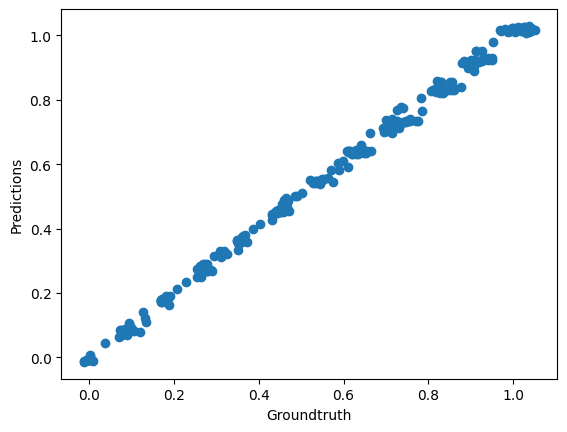

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
for idx, prediction in enumerate(predictions):
    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

Groundtruth: [0.6108032128179655]. Predicted: [0.63775367]
Groundtruth: [0.3637647593178142]. Predicted: [0.36262392]
Groundtruth: [0.27475760946099226]. Predicted: [0.27152966]
Groundtruth: [0.44240088013726675]. Predicted: [0.45313646]
Groundtruth: [0.8193969144175096]. Predicted: [0.82937243]
Groundtruth: [0.08375407545021021]. Predicted: [0.08111368]
Groundtruth: [0.07392311669740316]. Predicted: [0.08443439]
Groundtruth: [0.7367073712746771]. Predicted: [0.77755515]
Groundtruth: [0.44595585488837336]. Predicted: [0.45659522]
Groundtruth: [0.5877387094136142]. Predicted: [0.6037331]
Groundtruth: [0.7302719710668464]. Predicted: [0.71132353]
Groundtruth: [0.2547560244218358]. Predicted: [0.27391286]
Groundtruth: [0.3526711275258362]. Predicted: [0.36183933]
Groundtruth: [0.08227745521970097]. Predicted: [0.07768287]
Groundtruth: [0.08475546999139458]. Predicted: [0.08716037]
Groundtruth: [0.5321972262472037]. Predicted: [0.5432417]
Groundtruth: [0.1726582874511066]. Predicted: [0.17

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 9:11], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 12:14], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 15:17], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 18:20])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
model_fr_com_y.coef_

In [ ]:
model_fr_com_y.intercept_

In [ ]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [ ]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')